In [12]:
library(geojsonio)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(dplyr)
library("knitr")
library(broom)
library(stargazer)
library(units)
library(sf)
library(car)

In [13]:
# Read in the data
census_index_crime <- st_read("census_index_crime.geojson") |>
    mutate(across(c(immigrant_prop, education_prop, mean_land_value,income), as.double))|>
    na.omit()|>
    glimpse()

Reading layer `census_index_crime' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\census_index_crime.geojson' 
  using driver `GeoJSON'
Simple feature collection with 993 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -123.2242 ymin: 49.19853 xmax: -123.0229 ymax: 49.31408
Geodetic CRS:  WGS 84


Warning message:
"There were 4 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


Rows: 989
Columns: 19
$ name                 <chr> "59150307", "59150308", "59150309", "59150310", "…
$ households           <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174,…
$ dwellings            <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189,…
$ population           <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506…
$ population_density   <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 6…
$ region               <chr> "Vancouver", "Vancouver", "Vancouver", "Vancouver…
$ area_sq_km           <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08…
$ age                  <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510…
$ income               <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.74…
$ immigrant_prop       <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.404…
$ education_prop       <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.253…
$ school_index         <dbl> 1.074675, 1.252273, 1.426336, 2.441091, 1.543095,…
$ light_index     

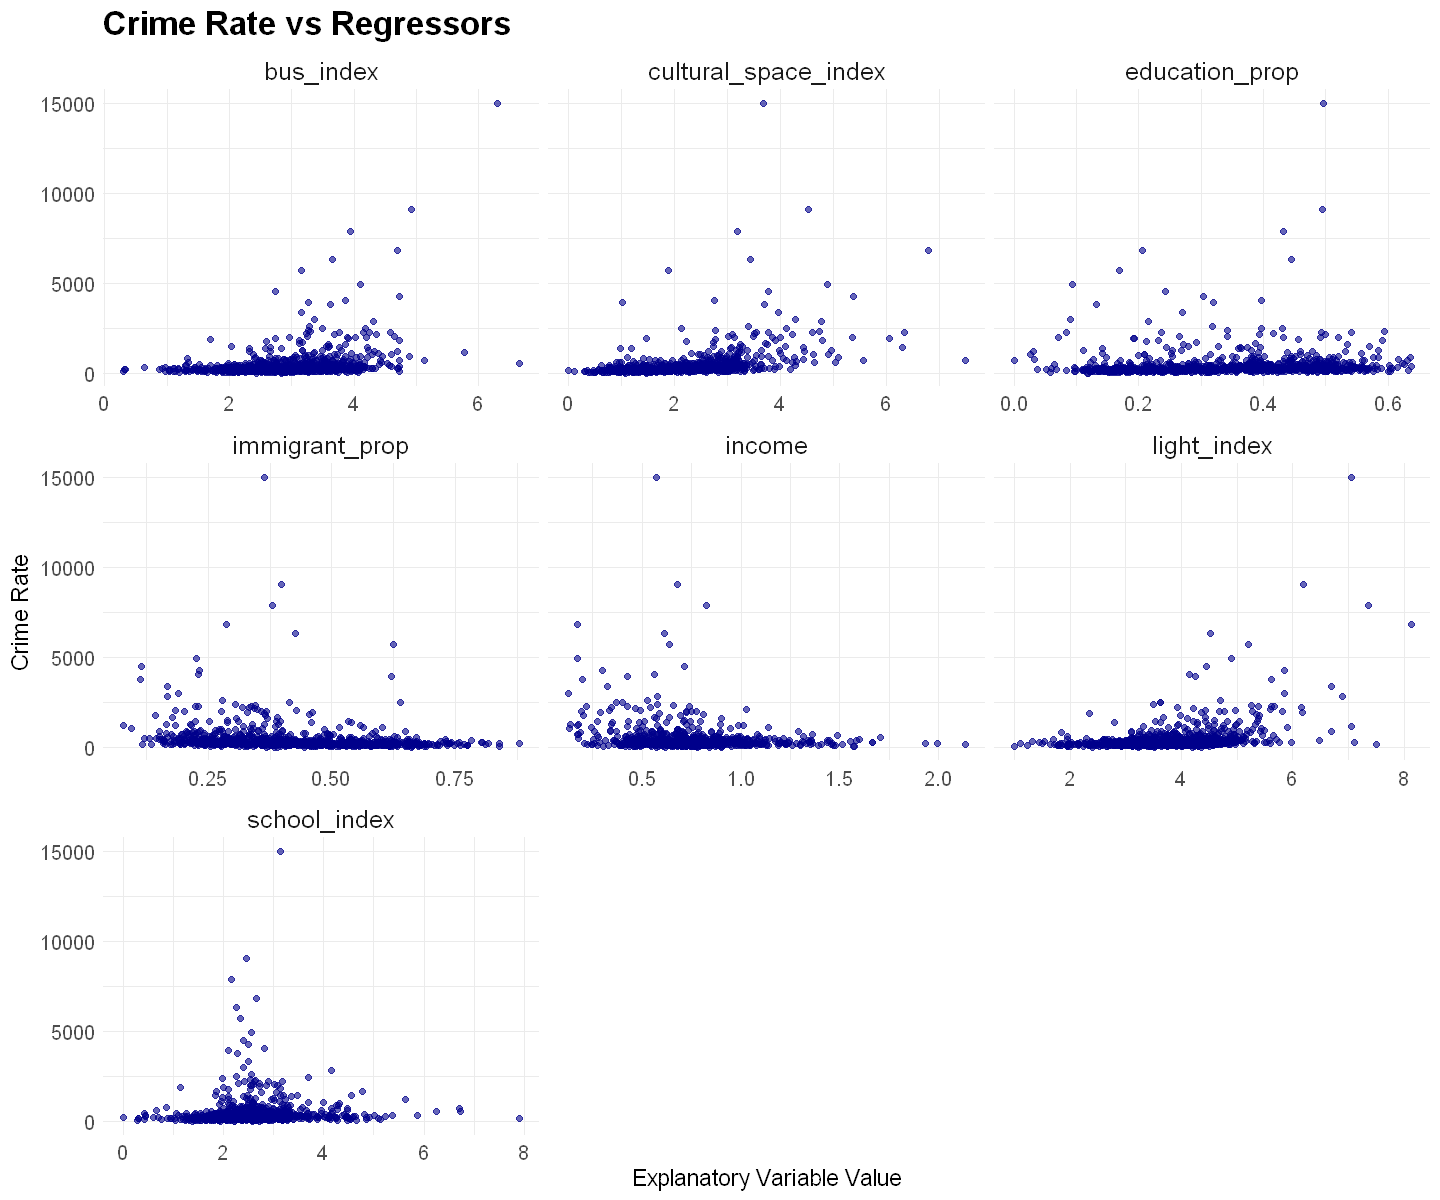

In [14]:
# Visualization of crime rate against regressors
options(repr.plot.width = 12, repr.plot.height = 10)

regressors <- c('school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

variables_scatter <- ggplot(long_data, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter

By eyeball method, it's clear that the data is itself heteoskedastic.

In [15]:
# Carry out all the simple regressions
outcome <- "crime_rate"

simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime))

names(simple_regressions) <- regressors

stargazer(simple_regressions, type = "text",
          title = "Simple Regression Results",
          dep.var.labels = c("Crime Rate"))


Simple Regression Results
                                                              Dependent variable:                               
                               ---------------------------------------------------------------------------------
                                                                  Crime Rate                                    
                                  (1)         (2)         (3)         (4)         (5)         (6)        (7)    
----------------------------------------------------------------------------------------------------------------
school_index                     45.570                                                                         
                                (33.063)                                                                        
                                                                                                                
light_index                               372.261***                 

`geom_smooth()` using formula = 'y ~ x'


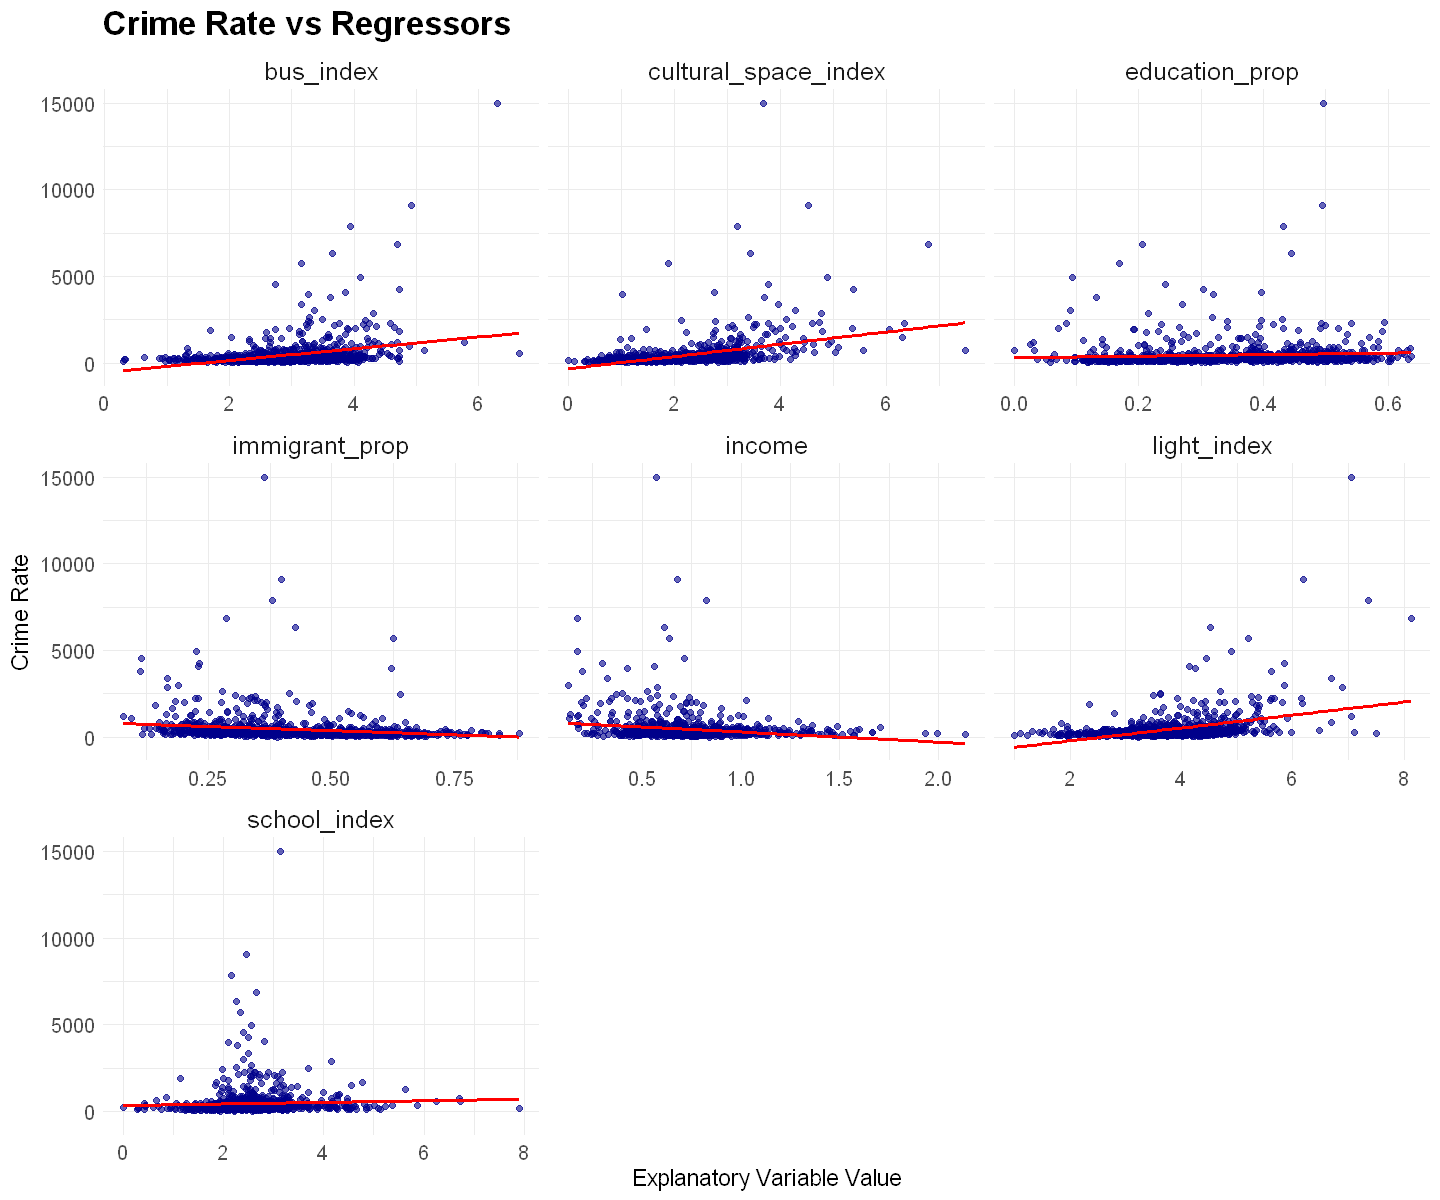

In [16]:
# Visualizing simple regressions
options(repr.plot.width = 12, repr.plot.height = 10)
simple_regression_plot <- variables_scatter +  geom_smooth(method = "lm", se = FALSE, color = "red") 

simple_regression_plot

In [17]:
# Test by running a model including all control
reg_all <- lm(crime_rate ~ school_index + light_index + bus_index + cultural_space_index + 
    income + immigrant_prop + education_prop, data = census_index_crime)
    
stargazer(reg_all, type = "text",
          title = "Regression With All Variable Results",
          dep.var.labels = c("Crime Rate"))


Regression With All Variable Results
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
school_index                 -288.633***        
                              (36.391)          
                                                
light_index                  371.573***         
                              (46.928)          
                                                
bus_index                      22.702           
                              (51.769)          
                                                
cultural_space_index         185.761***         
                              (43.953)          
                                                
income                       -280.434**         
                              (110.935)         
                                                
immigrant_prop                -

The regression output above suggests that bus_index, immigrant_prop, and education_prop variables may be insignificant for having p-values > 0.1

In [18]:
# Examining the vif of the model
vif(reg_all, type = "terms")

school_index          light_index            bus_index 
            1.607899             3.233803             3.064184 
cultural_space_index               income       immigrant_prop 
            3.189121             1.401212             1.627395 
      education_prop 
            1.570994

In [19]:
# Predict y_hat
y_hat <- predict(reg_all)

In [20]:
# Carry out white's test
white <- lm(census_index_crime$crime_rate - y_hat ~ y_hat + I(y_hat^2))

stargazer(white, type = "text",
          title = "White's Test",
          dep.var.labels = c("Residual"))


White's Test
                        Dependent variable:    
                    ---------------------------
                             Residual          
-----------------------------------------------
y_hat                        -1.047***         
                              (0.085)          
                                               
I(y_hat2)                    0.001***          
                             (0.0001)          
                                               
Constant                    163.507***         
                             (32.727)          
                                               
-----------------------------------------------
Observations                    989            
R2                             0.187           
Adjusted R2                    0.186           
Residual Std. Error     656.848 (df = 986)     
F Statistic          113.686*** (df = 2; 986)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [21]:
reg1 <- lm(crime_rate ~ school_index + light_index + cultural_space_index + 
    income, data = census_index_crime)

stargazer(reg1, type = "text",
          title = "Regression With Significant Controls",
          dep.var.labels = c("Crime Rate"))


Regression With Significant Controls
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
school_index                 -287.323***        
                              (34.776)          
                                                
light_index                  369.548***         
                              (36.862)          
                                                
cultural_space_index         217.168***         
                              (32.014)          
                                                
income                       -259.734***        
                              (97.443)          
                                                
Constant                     -479.589***        
                              (133.759)         
                                                
-------------------------------

In [22]:
stargazer(simple_regressions, reg1, reg_all,
          type = "text",  # Change to "html" or "latex" if needed
          title = "Regression Results",
          dep.var.labels = "Crime Rate")


Regression Results
                                                                                                                     Dependent variable:                                                                                                 
                     --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                  Crime Rate                                                                                                crime_rate                   
                             (1)                   (2)                      (3)                      (4)                      (5)                     (6)                    (7)                    (8)                     (9)          
--------------------------------------------